In [1]:
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

with open('data.pkl', 'rb') as f:
   Data = pickle.load(f)
    
bbox_list1 = Data['GT']
u = Data['annotaton']

image_data1 = np.transpose(Data['images'], (0, 3, 1, 2))
images = torch.tensor(image_data1)
images = images.to(dtype=torch.float32)

In [2]:
def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """

    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])

    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0

    # ------computing union------
    # sum of area of both the boxes - area_overlap

    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])

    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])

    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2

    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2

    # union
    area_union = area_union_overlap - area_overlap

    # compute IOU
    iou = area_overlap/ area_union

    return iou

def to_VOC_format(width, height, center_x, center_y):
    """
    Convert center coordinate format to min max coordinateformat
    """
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max

def to_center_format(xmin_list, ymin_list, xmax_list, ymax_list):
    """
    Convert min max coordinate format to x_center, y_center, height and width format
    """
    height = ymax_list - ymin_list
    width = xmax_list - xmin_list

    center_x = xmin_list + 0.5 * width
    center_y = ymin_list + 0.5 * height

    return width, height, center_x, center_y

def adjust_deltas(anchor_width, anchor_height, anchor_center_x, anchor_center_y, dx, dy, dw, dh):
    """
    Adjust the anchor box with predicted offset
    """
    # ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    center_x = dx * anchor_width + anchor_center_x

    # ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    center_y = dy *  anchor_height + anchor_center_y

    # w = np.exp(dw) * anc_width[:, np.newaxis]
    width = np.exp(dw) * anchor_width

    # np.exp(dh) * anc_height[:, np.newaxis]
    height = np.exp(dh) * anchor_height

    return width, height, center_x, center_y

stride = 8
w = h = 800

x_center = np.arange(3, w, stride) # [  0,  32,  64,  96, 128, 160, 192,...]
y_center = np.arange(3, h, stride) # [  0,  32,  64,  96, 128, 160, 192,...]

        # generate all the ordered pair of x and y center

        # to achive this, we will use meshgrid and reshape it
center_list = np.array(np.meshgrid(x_center, y_center,  sparse=False, indexing='xy')).T.reshape(-1,2)
    ##########################################################

    #al = []

#anchor_shape = [(4,4),(6,6),(10,10),(16,16),(22,22),(32,32)]
anchor_shape = [(8,8),(25,25),(38,38),(58,58),(85,85),(120,120)]
n_anchors = len(center_list) * len(anchor_shape)


anchor_list = np.zeros(shape= (n_anchors, 4))

count = 0
for center in center_list:
         center_x, center_y = center[0], center[1]
            # for each ratio
         for w,h in anchor_shape:
              # for each scale
             anchor_xmin,anchor_ymin,anchor_xmax,anchor_ymax = to_VOC_format(w, h, center_x, center_y)
             #al.append([center_x, center_y, w, h])
                    # append the anchor box to anchor list
             anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
             count += 1

In [3]:
def Get_RoI(RPN, image_data, bbox_list1, anchor_list, u, th2):
    # Initialize a list to store predicted RoIs
    predict_roi = []

    # Loop over each image in the batch
    for i in range(image_data.shape[0]):
        print(i)
        img = image_data[i:i+1,:,:,:]
        img = img.to(device)
        
        # Predict anchor deltas and objectness scores
        anchor_deltas, objectiveness_score = model(img)
        anchor_deltas = anchor_deltas.detach().numpy()
        objectiveness_score = objectiveness_score.detach().numpy()
        objectiveness_score = objectiveness_score.reshape(-1, n_anchors)
        anchor_deltas = anchor_deltas.reshape(-1, n_anchors, 4)

        # Extract deltas for adjustment
        dx, dy, dw, dh = anchor_deltas[:, :, 0], anchor_deltas[:, :, 1], anchor_deltas[:, :, 2], anchor_deltas[:, :, 3]

        # Convert anchor box coordinates to center format
        anchor_width, anchor_height, anchor_center_x, anchor_center_y = to_center_format(
            anchor_list[:, 0], anchor_list[:, 1], anchor_list[:, 2], anchor_list[:, 3])

        # Adjust the anchors using the predicted deltas to obtain the final RoIs
        roi_width, roi_height, roi_center_x, roi_center_y = adjust_deltas(
            anchor_width, anchor_height, anchor_center_x, anchor_center_y, dx, dy, dw, dh)

        # Convert RoIs back to VOC format
        roi_min_x, roi_min_y, roi_max_x, roi_max_y = to_VOC_format(roi_width, roi_height, roi_center_x, roi_center_y)
        roi = np.vstack((roi_min_x, roi_min_y, roi_max_x, roi_max_y)).T

        # Filter out small and big RoIs based on size thresholds
        min_size = 30
        max_size = 160
        width = roi[:, 2] - roi[:, 0]
        height = roi[:, 3] - roi[:, 1]
        keep = np.where((width >= min_size) & (height <= max_size) & (height >= min_size))[0]
        roi = roi[keep]
        score = objectiveness_score[:, keep]

        # Sort RoIs by objectiveness score
        sorted_idx = score.flatten().argsort()[::-1]
        roi_sorted = roi[sorted_idx]
        bbox_list = bbox_list1[i]

        # Final filtering based on region content
        imgg = np.reshape(img,(800,800,3))
        img1 = imgg[:,:,1]
        indd = []
        for ii in range(len(roi_sorted)):
            bbox_list11 = roi_sorted[ii]
            anchor_width1, anchor_height1, anchor_center_x1, anchor_center_y1 = to_center_format(
                bbox_list11[0], bbox_list11[1], bbox_list11[2], bbox_list11[3])
            
            img2 = img1[np.int64(anchor_center_x1-anchor_width1/2):np.int64(anchor_center_x1+anchor_height1/2),
                        np.int64(anchor_center_y1-anchor_width1/2):np.int64(anchor_center_y1+anchor_height1/2)]

            if (img2.shape[0]) > 0:
                indd.append(ii)
                if len(indd) >= th2:
                    break

        roi_sorted = roi_sorted[indd, :]
        predict_roi.append(roi_sorted)
      
    return predict_roi

In [4]:
# Import necessary libraries

# Define the CustomRPN class inheriting from nn.Module
class CustomRPN(nn.Module):
    def __init__(self, k=6, weight_decay=0.000001):
        super(CustomRPN, self).__init__()

        # Define the first set of convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer for downsampling

        # Define the second set of convolutional layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        # Continue adding more convolutional layers for deeper feature extraction
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
        # Define additional convolutional layers
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
        # Define a transposed convolutional layer for upsampling
        self.deconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=1, stride=2, padding=1, output_padding=1)

        # Define final convolutional layers for bounding box regression and classification
        self.conv15 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, padding=1)
        self.conv16 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)
        self.conv17 = nn.Conv2d(in_channels=512, out_channels=510, kernel_size=1)

        # Regressor for bounding box prediction and classifier for objectness score
        self.regressor = nn.Conv2d(in_channels=512, out_channels=4*k, kernel_size=1)
        self.classifier = nn.Conv2d(in_channels=512, out_channels=k, kernel_size=1)

    # Forward pass through the network
    def forward(self, x):
        x1 = F.relu(self.conv1(x))  # First convolutional block
        x2 = F.relu(self.conv2(x1))
        p1 = self.pool(x2)
        
        x3 = F.relu(self.conv3(p1))  # Second convolutional block
        x4 = F.relu(self.conv4(x3))
        p2 = self.pool(x4)
        
        x5 = F.relu(self.conv5(p2))  # Third convolutional block
        x6 = F.relu(self.conv6(x5))
        x7 = F.relu(self.conv7(x6))
        p3 = self.pool(x7)
        
        x8 = F.relu(self.conv8(p3))  # Fourth convolutional block
        x9 = F.relu(self.conv9(x8))
        x10 = F.relu(self.conv10(x9))
        p4 = self.pool(x10)
        
        x11 = F.relu(self.conv11(p4))  # Fifth convolutional block
        x12 = F.relu(self.conv12(x11))
        x13 = F.relu(self.conv13(x12))
        
        x14 = self.deconv1(x13)  # Upsampling with transposed convolution
        x15 = self.conv15(x14)

        # Additional convolutions for feature maps at different stages
        x18 = self.conv16(p3)
        x19 = self.conv17(x10)
        
        # Concatenate feature maps from different layers
        concatenated = torch.cat([x15, x19, x18], dim=1)
        
        # Predict bounding boxes (regressor) and objectness score (classifier)
        regressor = self.regressor(concatenated)
        classifier = torch.sigmoid(self.classifier(concatenated))

        return regressor, classifier

# Load the entire model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomRPN()
# Load the saved model weights
ww = 'RPN_torch'
model = torch.load(ww+".pth", map_location=torch.device('cpu'))
model.eval()  # Set the model to evaluation mode


C:\Users\Amir\AppData\Local\Temp\ipykernel_21652\51013407.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(ww+".pth", map_location=torch.device('cpu')

CustomRPN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_siz

The goal of this code is to extract and classify image regions from a dataset based on predicted regions of interest (RoIs) from a model. It processes each image by cropping and resizing areas defined by bounding boxes and RoIs, categorizing them into positive or negative examples.

In [ ]:
# Copy all data from images tensor
image_data2 = images[:, :, :, :]
number, _, _, _ = image_data2.shape  # Extract the number of images

th2 = 100  # Set threshold value for number of RoIs to process
# Get sorted RoIs based on the model's output
roi_sorted1 = Get_RoI(model, image_data2, bbox_list1, anchor_list, u, th2)

image_fpr = []  # Initialize list to store region images
label = []  # Initialize list to store labels for images
k = 0  # Counter for number of processed images

# Loop through each image
for i in range(number):
    print(i)  # Print the current image index
    img = Data['images'][i, :, :, 1]  # Extract image for the current index
    bbox = bbox_list1[i, :]  # Extract bounding box for the current index
    
    # Crop image based on bounding box and resize
    img2 = img[np.int64(bbox[0]):np.int64(bbox[2]), np.int64(bbox[1]):np.int64(bbox[3])]
    img3 = cv2.resize(img2, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
    
    # Append resized image and label to lists
    image_fpr.append(img3)
    label.append(1)  # Label 1 for positive examples
    k += 1  # Increment counter for processed images
    num_count = 0  # Counter for number of negative samples added
    
    # Process RoIs to identify potential false positives
    roi_sorted = roi_sorted1[i]
    for k1 in range(th2):
        iou1 = IOU(bbox, roi_sorted[k1])  # Compute Intersection over Union (IoU)
        bbox0 = roi_sorted[k1]
        dia1 = bbox0[2] - bbox0[0]  # Width of bounding box
        dia2 = bbox0[3] - bbox0[1]  # Height of bounding box
        dia_min = min([dia1, dia2])  # Minimum dimension
        dia_max = max([dia1, dia2])  # Maximum dimension

        # Check conditions for adding negative samples
        if (iou1 == 0) & (dia_min > 10) & (dia_max < 120):
            img2 = img[np.int64(bbox0[0]):np.int64(bbox0[2]), np.int64(bbox0[1]):np.int64(bbox0[3])]
            img3 = cv2.resize(img2, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
            
            if np.mean(img3) != 0:  # Ensure non-empty image
                label.append(0)  # Label 0 for negative examples
                image_fpr.append(img3)
                k += 1
                num_count += 1
                
            if num_count == 3:  # Stop after collecting 3 negative samples
                break

    # Add additional positive samples with high IoU
    count = 0
    for k1 in range(th2):
        iou1 = IOU(bbox, roi_sorted[k1])  # Compute Intersection over Union (IoU)
        bbox0 = roi_sorted[k1]
        if (iou1 > 0.7) & (count < 2):
            img2 = img[np.int64(bbox0[0]):np.int64(bbox0[2]), np.int64(bbox0[1]):np.int64(bbox0[3])]
            img3 = cv2.resize(img2, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
            image_fpr.append(img3)
            label.append(1)  # Label 1 for positive examples
            k += 1
            count += 1

# Save images and labels to pickle files
data = {'output': image_fpr}
with open('Image_LUNG.pkl', 'wb') as file:
    pickle.dump(data, file)

label = {'output': label}
with open('label_LUNG.pkl', 'wb') as file:
    pickle.dump(label, file)


This code loads image and label data from pickle files, retrieves a specific image and its label using a predefined index (Num_image), and displays the selected image using Matplotlib. It sets the plot title to "Nodule" if the label indicates the presence of a nodule (1), or "Non-Nodule" if the label indicates its absence (0). The image is shown in grayscale, providing a visual representation of the data along with a descriptive title based on its label.

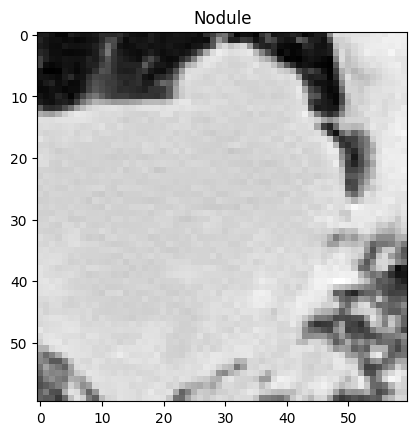

In [22]:
# Load the image data from a pickle file
with open('Image_LUNG.pkl', 'rb') as f:
   image = pickle.load(f)  # Load the dictionary containing image data

# Load the label data from a pickle file
with open('label_LUNG.pkl', 'rb') as f:
   label1 = pickle.load(f)  # Load the dictionary containing label data

Num_image = 8  # Set the index of the image to be displayed

# Extract the selected image using the index
img_test = image['output'][Num_image]

# Create a figure and axes for plotting
fig, ax = plt.subplots()

# Display the selected image in grayscale
plt.imshow(img_test, cmap='gray')

# Set the title of the plot based on the label of the selected image
if label1['output'][Num_image] == 1:
    ax.set_title('Nodule')  # Title for positive examples
else:
    ax.set_title('Non-Nodule')  # Title for negative examples

# Show the plot with the image and title
plt.show()
